# Simulation Analysis Notebook

This Jupyter Notebook is designed to introduce a user to the PyGkyl library (unofficial naming). 
It includes many different examples of diagnostic tools that can be used to analyze Gkeyll GK simulation data. 

Antoine C.D. Hoffmann (@antoinehoff) -- Jan 13, 2025

## Table of Contents
0. [Installation of pygkyl](#install)<br>
1. [Prologue](#prologue)<br>
    1.1 [Setup and Imports](#setup_imports)<br>
    1.2 [Simulation Data Setup](#data_setup)<br>
    1.3 [Simulation Class Initialization](#simulation_class)<br>
    1.4 [Source Profiles and Input Power](#sources)<br>
    1.5 [Time Frame and normalization](#time_frames)<br>

2. [Simulation Data Analysis](#sim_analysis)<br>
    2.1 [1D Profile Relaxation](#1d_profile)<br>
    2.2 [Space-Time Diagrams](#space_time)<br>
    2.3 [Two-Dimensional Cut](#2d_cut)<br>
    2.4 [Space-Time Fluctuation](#st_fluct_plot)<br>
    2.5 [Two-Dimensional Fluctuation](#2d_fluct_plot)<br>
    2.6 [Time-Averaged Profile](#time_averaged_profile)<br>
    2.7 [Movie Generator](#movie_generator)<br>
    2.8 [Flux Surface Time-Average Profiles](#fs_time_averaged_profile)<br>
    2.9 [Time series](#time_series)<br>
    2.10 [Phase Space Analysis](#dist_funct)<br>
    2.11 [DG Representation](#dg_rep)<br>
    2.12 [Poloidal projection plot](#pol_plot)<br>
    2.13 [Flux surface projection plot](#fs_plot)<br>
    2.14 [Full torus projection plot](#tor_plot)<br>

3. [Interfaces](#interfaces)<br>
    3.1 [Thungsten transport with Flan](#flan)<br>
    3.2 [Local GK flux tube simulations with GYACOMO](#gyacomo)<br>

## 0. Installation of pygkyl <a id="install"></a>
Here we will install pygkyl, a Python package for working with GKYL data structures and analyzing numerical simulations of turbulence in tokamaks.
Uncomment the lines below to install or refresh pygkyl and its dependencies.

In [1]:
path_to_pygkyl = '~/personal_gkyl_scripts/'
import sys
import os
if path_to_pygkyl not in sys.path:
    sys.path.append(os.path.expanduser(path_to_pygkyl))

if not os.path.exists(os.path.join(os.path.expanduser(path_to_pygkyl), '.git')):
    os.system(f'git clone https://github.com/Antoinehoff/personal_gkyl_scripts.git {path_to_pygkyl}')
else:
    os.system(f'cd {os.path.expanduser(path_to_pygkyl)} && git pull')
    
# run the installation script
script_path = os.path.join(path_to_pygkyl, 'scripts/pygkyl_install.py')
os.system(f'python3 {script_path}');
# to avoid pulling: os.system(f'python3 {script_path} --no-pull');

Already up to date.
Installing pygkyl and dependencies...
-Base path: /Users/ahoffman
-Postgkyl path: /Users/ahoffman/postgkyl
-Personal gkyl scripts path: /Users/ahoffman/personal_gkyl_scripts
-Pygkyl path: /Users/ahoffman/personal_gkyl_scripts/pygkyl


1.0 Check if postgkyl repository exists
1.1 Pull postgkyl repository
Already up to date.
1.2 Install postgkyl (required for pygkyl)
2.0 Check if personal_gkyl_scripts repository exists
2.2 Pull personal_gkyl_scripts repository
Already up to date.
2.3 Remove old pygkyl egg-info and build directories
2.4 Install pygkyl (personal gkyl scripts)
->pygkyl installed successfully


We can now import the library.

In [2]:
import pygkyl

## 1. Prologue <a id="prologue"></a>
This section imports necessary libraries and custom routines required for the analysis. It also builds a Simulation class instance that will deliver helpful data to the plotting routine. Finally, it looks for the available simulation frames.

### 1.1 Simulation Data Path <a id="data_setup"></a>
Set up the path to the simulation data and its file prefix.

In [3]:
simdir = '/Users/ahoffman/personal_gkyl_scripts/sim_data/3x2v/gk_tcv_adapt_src/'
fileprefix = 'rt_gk_tcv_nt_iwl_3x2v_p1'

### 1.2 Simulation Class Initialization <a id="simulation_class"></a>
Initialize the `Simulation` class (see /python_utilities/classes/simulation.py) and set physical and geometric parameters.

The simulation class is made to contain every parameter and information about the simulation we want to analyze. It is meant to store geometry, metric, where the data are located and how they were generated. It will be used by all plot and post processing routines.

It should be the main entry point for the usage of pygkyl as most of the feature are accessible through a routine of this class.

Here we use a predefined configuration for the TCV simulation. Other configurations are available 

In [4]:
simulation = pygkyl.load_sim_config(configName='tcv_nt', simDir=simdir, filePrefix=fileprefix)

In [5]:
# To verify that the plot routines work:
simulation.test_plots()

Testing plot_1D...
Testing plot_DG_1D...
Testing plot_2D...
Testing plot_1D_time_evolution...
Testing plot_integrated_moment...
Testing plot_time_serie...
Testing plot_poloidal_projection...
Testing plot_flux_surface_projection...
Testing plot_balance...
Testing plot_loss...
All plotting tests completed successfully!


In [6]:
# Print the available diagnostics
simulation.data_param.info()

A table of the default quantities and their default units:
| Quantity        | Symbol                         | Units                |
|-----------------|--------------------------------|----------------------|
| Apardot         | $\partial_t A_\parallel$       | V/m                  |
| Apar            | $A_\parallel$                  | V s/m                |
| BM_Tpare        | $T_{\parallel e}$              | J/kg                 |
| BM_Tpari        | $T_{\parallel i}$              | J/kg                 |
| BM_Tperpe       | $T_{\perp e}$                  | J/kg                 |
| BM_Tperpi       | $T_{\perp i}$                  | J/kg                 |
| BM_ne           | $n_e$                          | m$^{-3}$             |
| BM_ni           | $n_i$                          | m$^{-3}$             |
| BM_upare        | $u_{\parallel e}$              | m/s                  |
| BM_upari        | $u_{\parallel i}$              | m/s                  |
| Bmag            | $B$      

### 1.3 Normalization <a id="time_frames"></a>
We can set up different units for the quantity we want to study (the list is above). These calls will adapt automatically all field that is loaded afterwards and the plot labels.

A default normalization is set when the Simulation class is initialized. Here we give an example of how to change the time normalization to a different unit.

In [7]:
# Change the time normalization to t a/c_s
simulation.normalization_change(key='time', 
                                scale=simulation.geom_param.a_mid/simulation.get_c_s(), 
                                shift=0.0, 
                                symbol=r'$t a/c_s$', 
                                unit='')
# Alternatively, you can set the time normalization to micro-seconds using a preset
simulation.normalization_set('t','mus')
# You can also reset all normalizations to default values
simulation.normalization_reset()
# Or set a default set of normalizations
simulation.normalization_default()

## 2. Simulation Data Analysis <a id="sim_analysis"></a>
We now use the plot routines defined in `python_utilities/tools/plot_utils.py` to generated various plots from the Simulation instance.
You can use `simulation.data_param.help()` to display what fields are available

In [8]:
# simulation.data_param.info()

We look for frames in the simulation data directory and store them in a list that will be used through the whole notebook.

In [9]:
sim_frames = simulation.available_frames['field'] # you can check the available frames for each data type like ion_M0, ion_BiMaxwellian, etc.)
sim_frames_ps = simulation.available_frames['ion'] # phase space data available
print("%g time conf. space frames available (%g to %g)"%(len(sim_frames),sim_frames[0],sim_frames[-1]))
print("%g time phase space frames available (%g to %g)"%(len(sim_frames_ps),sim_frames_ps[0],sim_frames_ps[-1]))

6 time conf. space frames available (0 to 5)
2 time phase space frames available (0 to 4)


Plot the integrated moment diagnostic. Additional options for computing the time derivative `ddt` and plotting only on a specific time interval `twindow` are available.

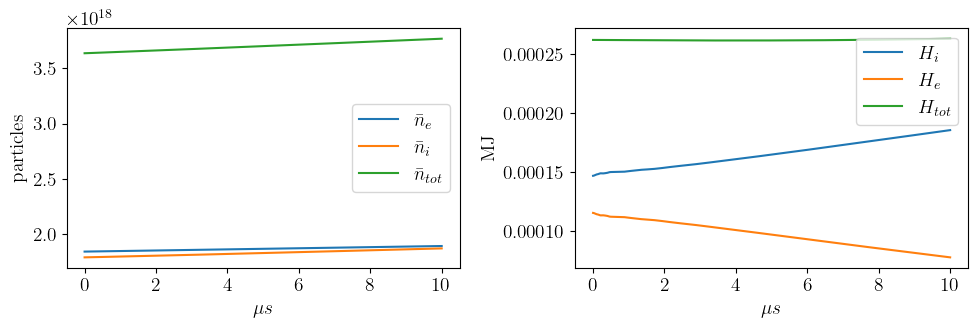

In [10]:
fieldnames = [['ne','ni','ntot'],['Wi','We','Wtot']] # this is for Bimaxwellian moments
output = simulation.plot_integrated_moment(field_name=fieldnames,ddt=False,twindow=[])

One can also check the integrated Hamiltonian and boundary fluxes if we are using a recent version of gkylzero (March 2025).

In [11]:
# fieldnames = [['ne','ni','ntot'],['He','Hi','Htot']]
# time = pygkyl.plot_utils.plot_integrated_moment(simulation,fieldnames=fieldnames, ddt=True)
# fieldnames = [['bflux_x_l_ntot','bflux_x_u_ntot','bflux_z_l_ntot','bflux_z_u_ntot','bflux_total_ntot'],
#               ['bflux_x_l_Htot','bflux_x_u_Htot','bflux_z_l_Htot','bflux_z_u_Htot','bflux_total_Htot']]
# time = pygkyl.plot_utils.plot_integrated_moment(simulation,fieldnames=fieldnames, ddt=True)

With access to boundary fluxes, we can also compute the power and particle balance and see it here

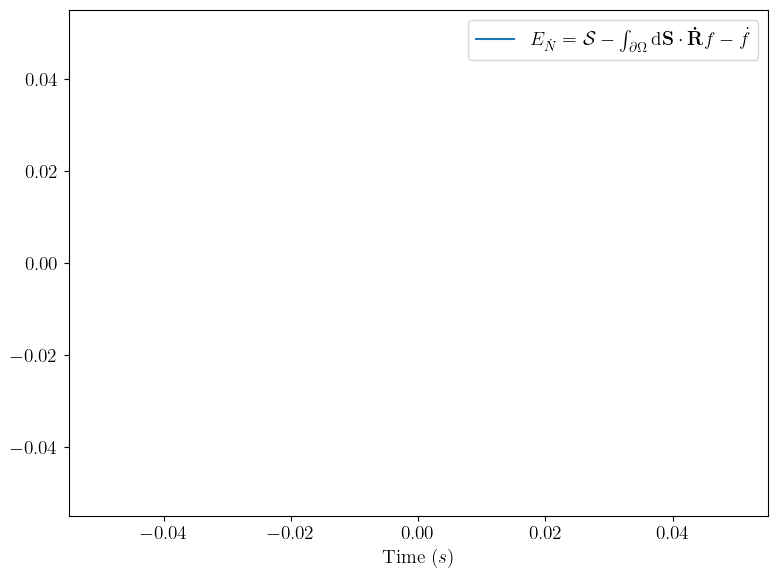

In [12]:
simulation.plot_balance('particle')

### 2.1 Profile relaxation <a id="1d_profile"></a>
Plot 1D cuts for multiple time frames.
- `cut_direction`   The dimension that remains after the cut. Can be 'x','y','z' and 'ky'.
- `cut_coords`      The coordinate of the cut, can be a double corresponding to the physical position (in the normalized units defined above), an integer to select an index or 'avg' to average over the dimension.
- `fieldnames`      The fields we want to plot. An array of char will create a multi plot. (see simulation.display_available_fields())
- `frames`          The frames to plot


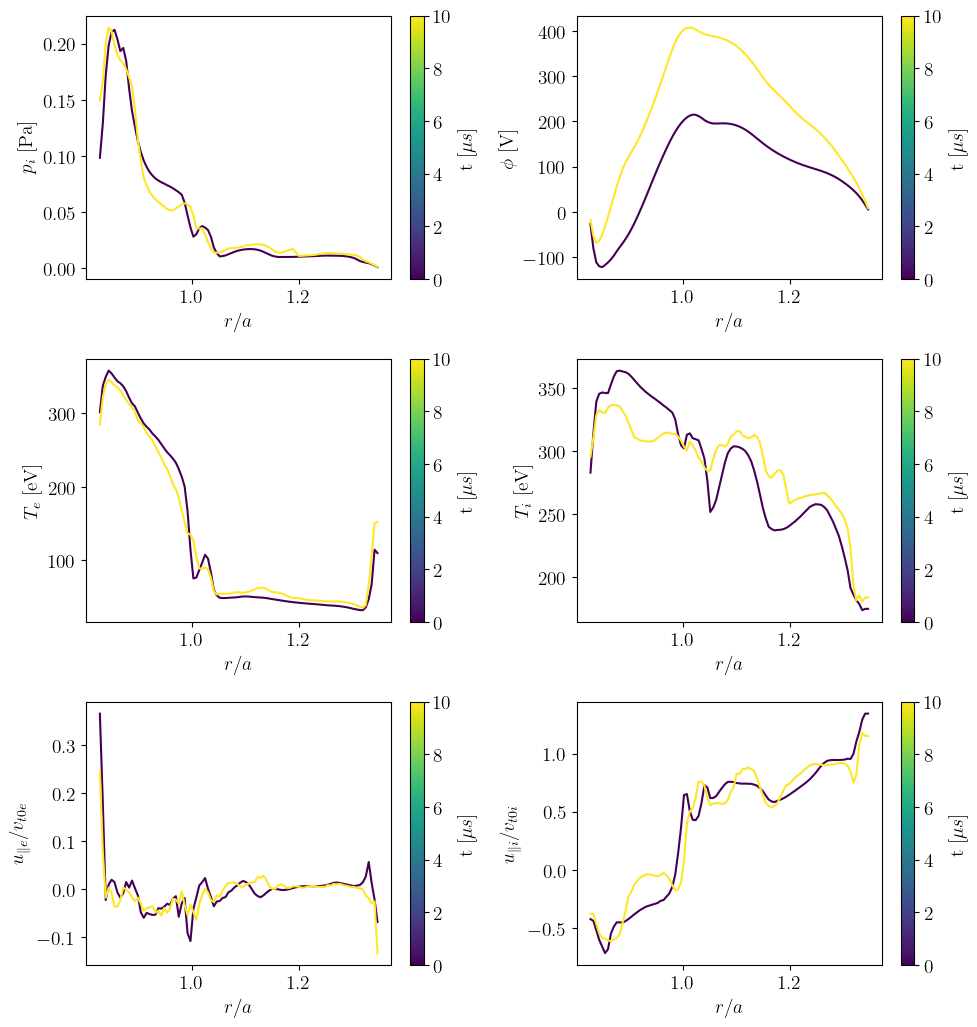

In [ ]:
simulation.plot_1D_time_evolution(cut_dir='x', 
                                  cut_coords=[0.0,0.0],
                                  field_name= ['pi','phi','Te','Ti','upare','upari'],
                                  frame_indices=sim_frames[::5],
                                  space_time=False,
                                  show_title=True)

### 2.2 Space-Time Diagrams <a id="space_time"></a>
Generate space-time diagrams for specified fields. Very useful to see the dynamics without a movie

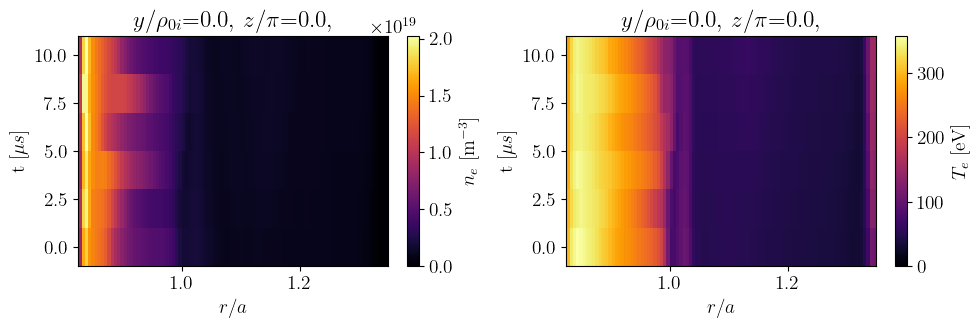

In [14]:
simulation.plot_1D_time_evolution(cut_dir='x', 
                                  cut_coords=[0.0,0.0],
                                  field_name= ['ne','Te'],
                                  frame_indices=sim_frames[-10:],
                                  space_time=True)

We can also plot any cut with a y-Fourier transform, which is useful to see the main modes of the system.

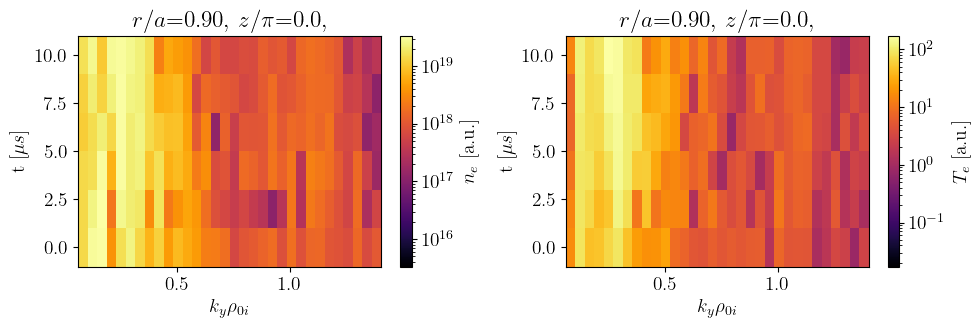

In [15]:
simulation.plot_1D_time_evolution(cut_dir='ky', 
                                  cut_coords=[0.9,0.0],
                                  field_name= ['ne','Te'],
                                  frame_indices=sim_frames[-10:],
                                  space_time=True)

### 2.3 Two-dimensional Cut <a id="2d_cut"></a>
Generate a 2D cut plot at a specified plane and time frame.

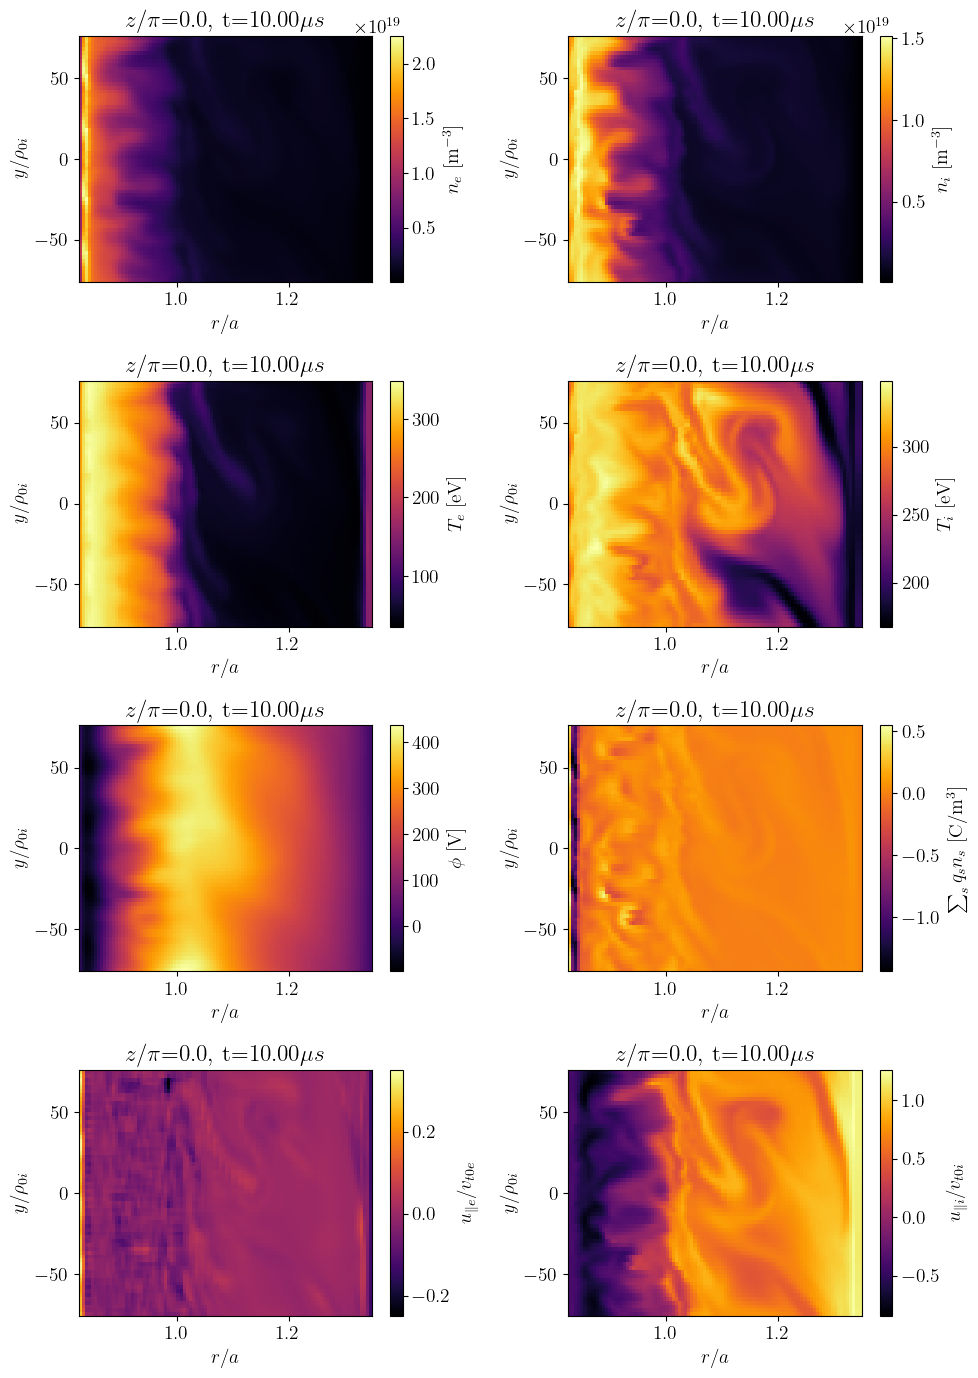

In [16]:
simulation.plot_2D(cut_dir='xy',
                   cut_coords=0.0,
                   frame_idx=sim_frames[-1],
                   field_name=['ne', 'ni', 'Te', 'Ti', 'phi', 'qdens', 'upare', 'upari'],
                   plot_type='pcolormesh')

### 2.4 Space Time and 2D cut Fluctuation <a id="st_fluct_plot"></a>
Generate a fluctuation plot by averaging over a time window and then substracting this average to each time frame. The average is performed against time only. If `coords` is set to be 'avg', additional averages are performed for both background and fluctuations.

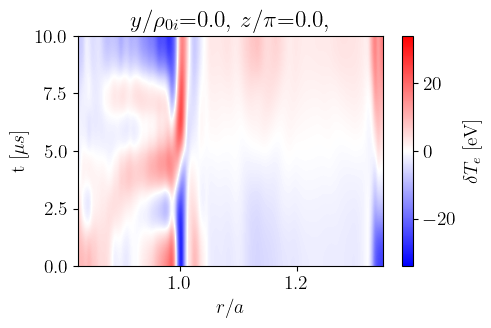

In [17]:
simulation.plot_1D_time_evolution(cut_dir='x',
                                  cut_coords=[0.0,0.0],
                                  field_name= ['Te'],
                                  frame_indices=sim_frames[-10:],
                                  space_time=True,
                                  fluctuation='tavg',
                                  plot_type='imshow')

### 2.5 Two-Dimensional Fluctuation <a id="2d_fluct_plot"></a>
Display the fluctuation of a field on a 2D plane
We can set `fluctuation='opt1_opt2'` where `opt1` can be 'tavg' or 'yavg', for fluctuation to the time average or the y average respectively. `opt2` can be 'relative' to have a relative fluctuation in percents.

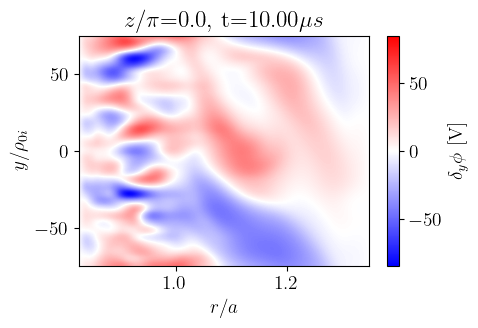

In [18]:
simulation.plot_2D(cut_dir='xy',
                   cut_coords=0.0,
                   frame_idx=sim_frames[-1],
                   field_name=['phi'],
                   fluctuation='yavg',
                   plot_type='imshow')

### 2.6 Time-Averaged Profile  <a id="time_averaged_profile"></a>
Here we show the ExB shear averaged over time of the last 50 frames. We generate also error bars that are related to the standard deviation.

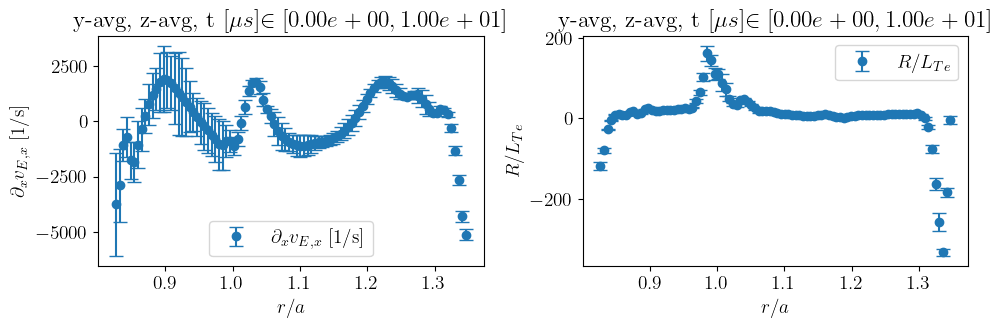

In [19]:
simulation.plot_1D(cut_dir='x',
                   cut_coords=['avg','avg'],
                   field_name=['ExB_s_x_x','gradlogTe'],
                   frame_idx=sim_frames[-20:],
                   errorbar=True)

### 2.7 Movie Generator <a id="movie_generator"></a>
Create a first movie of 2D cuts over time and a second of the fluctuations over the last 25 frames

In [20]:
moviename = simulation.make_movie(plot_function=simulation.plot_2D, 
                      movieprefix='movie_example_2D',
                      frame_list=sim_frames[-100:],
                      cut_dir='xy',
                      cut_coords=0.0,
                      clim = [0,400],
                      field_name=['Ti'],
                      plot_type='pcolormesh')

Processing frames: 6/6... 
Compiling movie: movie_example_2D_frames_0_to_5
Creating movie movie_example_2D_frames_0_to_5.gif...
movie movie_example_2D_frames_0_to_5.gif created.


We can also make a movie of fluctuations. The background is the average of the values during the movie time.

In [21]:
simulation.make_movie(plot_function=simulation.plot_2D, 
                      movieprefix='movie_example_2D_fluct',
                      frame_list=sim_frames[-2:],
                      cut_dir='xy',
                      cut_coords=0.0,
                      fluctuation='yavg',
                      field_name=['Ti'],
                      plot_type='imshow')

Processing frames: 2/2... 
Compiling movie: movie_example_2D_fluct_frames_4_to_5
Creating movie movie_example_2D_fluct_frames_4_to_5.gif...
movie movie_example_2D_fluct_frames_4_to_5.gif created.


'movie_example_2D_fluct_frames_4_to_5'

### 2.8 Flux Surface Time-Average Profiles <a id="fs_time_averaged_profile"></a>
We also add a small example on how to save the figure. You can replot it by following the example in `pygkyl/examples/load_figout.py`.

In [22]:
figout = []
simulation.plot_1D(cut_dir='x',
                   cut_coords=['avg','avg'],
                   field_name=[['ne','ni'],['upare','upari'],
                               ['Te','Ti'],['pe','pi']],
                   frame_idx=sim_frames[-2:],
                   errorbar=False,
                   figout=figout,
                   close_fig=True)
pygkyl.fig_tools.save_figout(figout,'fig_profiles') # this allows you to reload and replot with additional data
# You can reopen the figure later with:
# figout[0]

fig_profiles.pkl saved.


### 2.9 Time series <a id="time_series"></a>


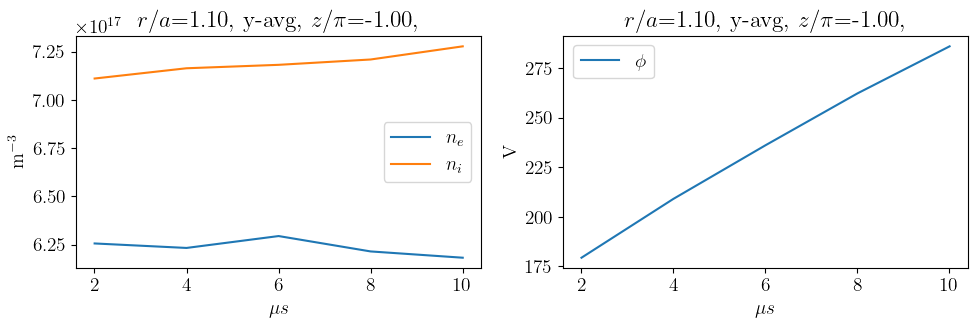

In [23]:
simulation.plot_time_serie(field_name=[['ne','ni'],'phi'],
                           cut_coords=[1.1,'avg',0],
                           time_frames=sim_frames[-5:])

### 2.10 Phase Space Analysis <a id="dist_funct"></a>
The distribution functions can also be plotted with the pygkyl routines. It will be slower than 3D fields as the files are usually much larger. One can plot all kinds of cuts in phase space  like 'xy', 'xz', 'xvpar', 'xmu', 'yvpar', 'ymu', 'zvpar', 'zmu', 'vparmu', providing a corresponding 3D cut in phase space.
One has to be sure that the `mapc2p_vel` and the `jacovel` files are also present in the data directory.

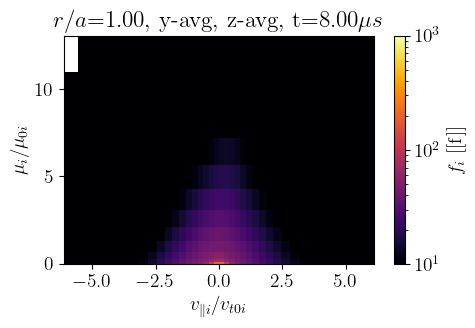

In [24]:
simulation.plot_2D(cut_dir='vparmu',
                   cut_coords=[1.0,'avg','avg'],
                   frame_idx=sim_frames_ps[-1],
                   field_name=['fi'],
                   plot_type='pcolormesh',
                   colorscale='log',
                   clim=[1e1,1e3])

We can study the the distribution of the ion parallel velocity across the radial direction at the sheath entrance. Here we average over the y direction, the average along mu is not working yet.

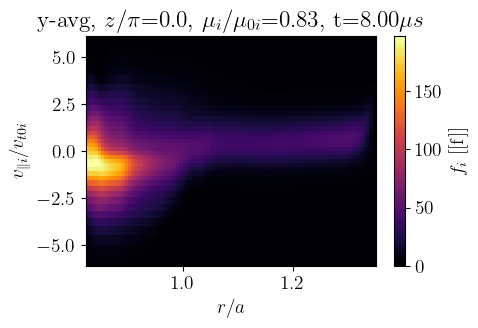

In [25]:
simulation.plot_2D(cut_dir='xvpar',
                   cut_coords=['avg',0.0,1.0],
                   frame_idx=sim_frames_ps[-1],
                   field_name=['fi'],
                   plot_type='pcolormesh')

todo list: - average over mu - allow for poloidal and other projections - allow to integrate selectrively over vpar or mu.

### 2.11 DG representation <a id="dg_rep"></a>
Plot the data in the DG form with cells and segments (1D only)

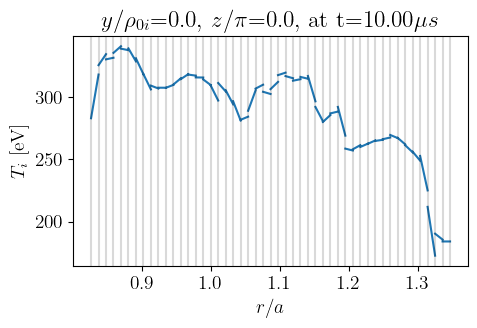

In [26]:
fieldname = 'Ti'
sim_frame = sim_frames[-1]
cutdir = 'x'
cutcoord = [0.0, 0.0]
xlim = []
simulation.plot_DG_1D(cut_dir='x',
                       cut_coords=[0.0,0.0],
                       field_name='Ti',
                       frame_idx=sim_frames[-1])

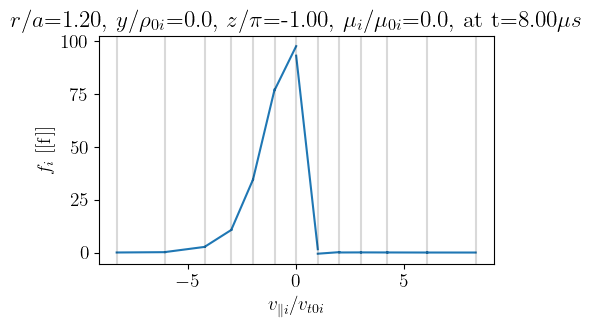

In [27]:
simulation.plot_DG_1D(cut_dir='vpar',
                       cut_coords=[1.2,0.0, 0, 0.0],
                       field_name='fi',
                       frame_idx=sim_frames_ps[-1])

### 2.12 Poloidal projection plot <a id="pol_plot"></a>
Project the flux tube on a poloidal plane (play with `nzInterp` to change resolution vs comp. time).

First we declare a poloidal projection object and set it up (declaring it upfront spares some run time as it can be reused for different plots.)

In [28]:
polproj = pygkyl.PoloidalProjection()
polproj.setup(
    simulation,
    nzInterp=24, # multiplication factor for the number of points in the poloidal direction
    timeFrame=sim_frames[0],  # time frame to load to get resolution info
    dpi=150,
    figSize=(8,9),
    )

Now we can plot different fields like the ion pressure in a logarithmic scale:

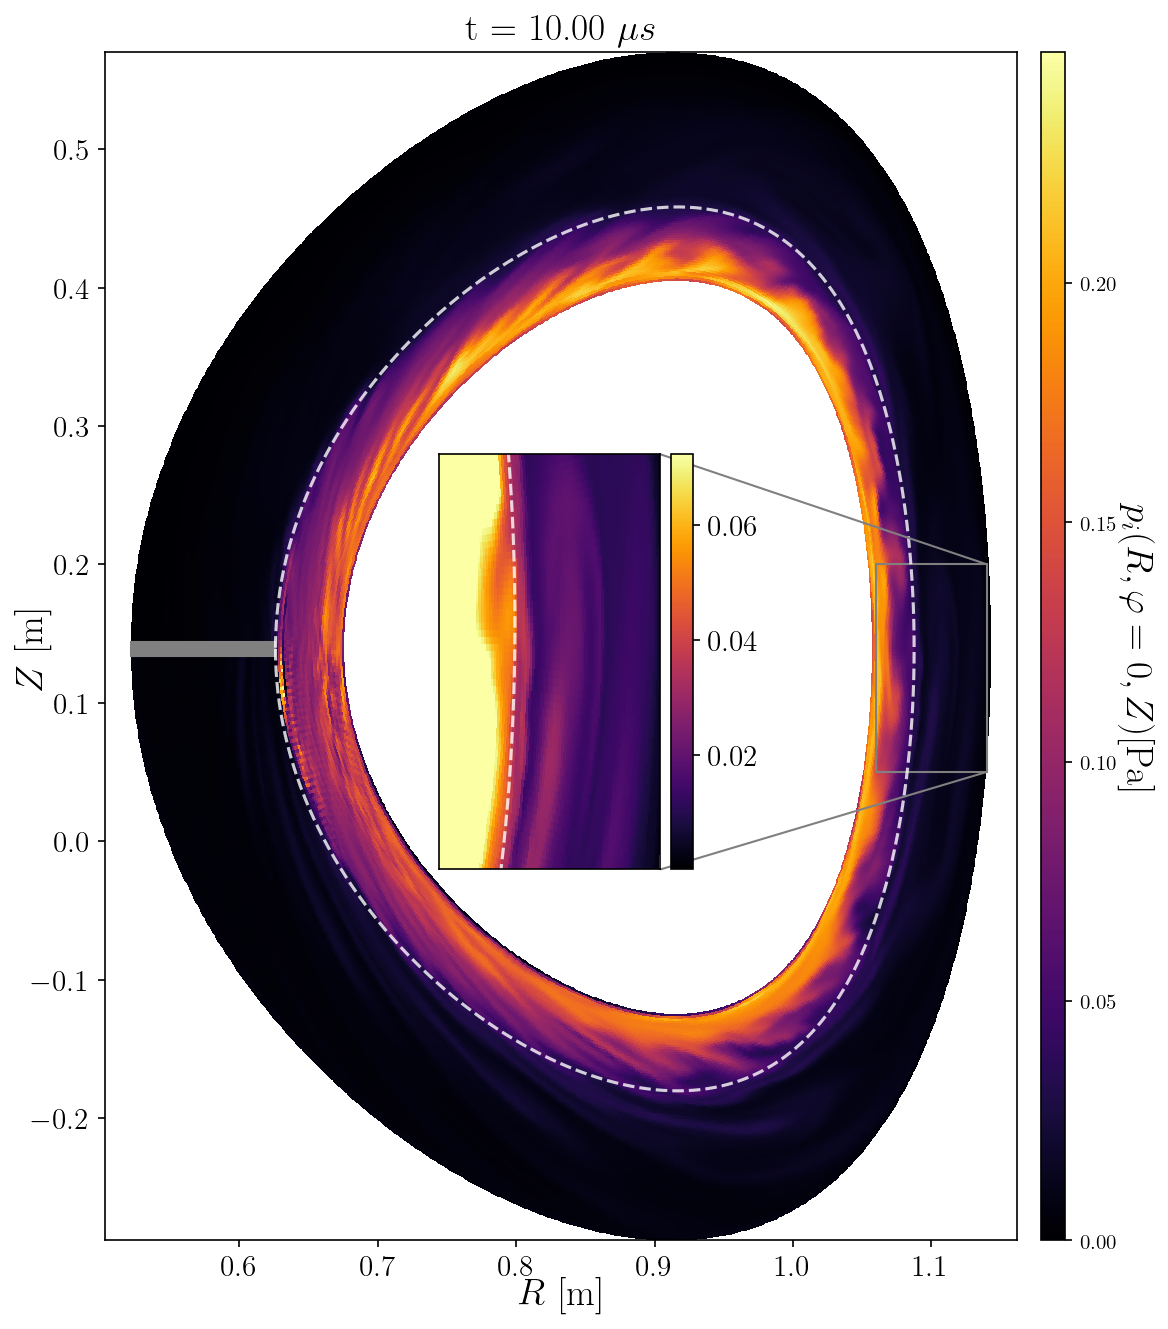

In [29]:
polproj.plot('pi',timeFrame=sim_frames[-1],colorScale='linear',clim=[])

We can also plot the fluctuations (also available for movies)
And change teh inset (here is the default one for tcv geom)

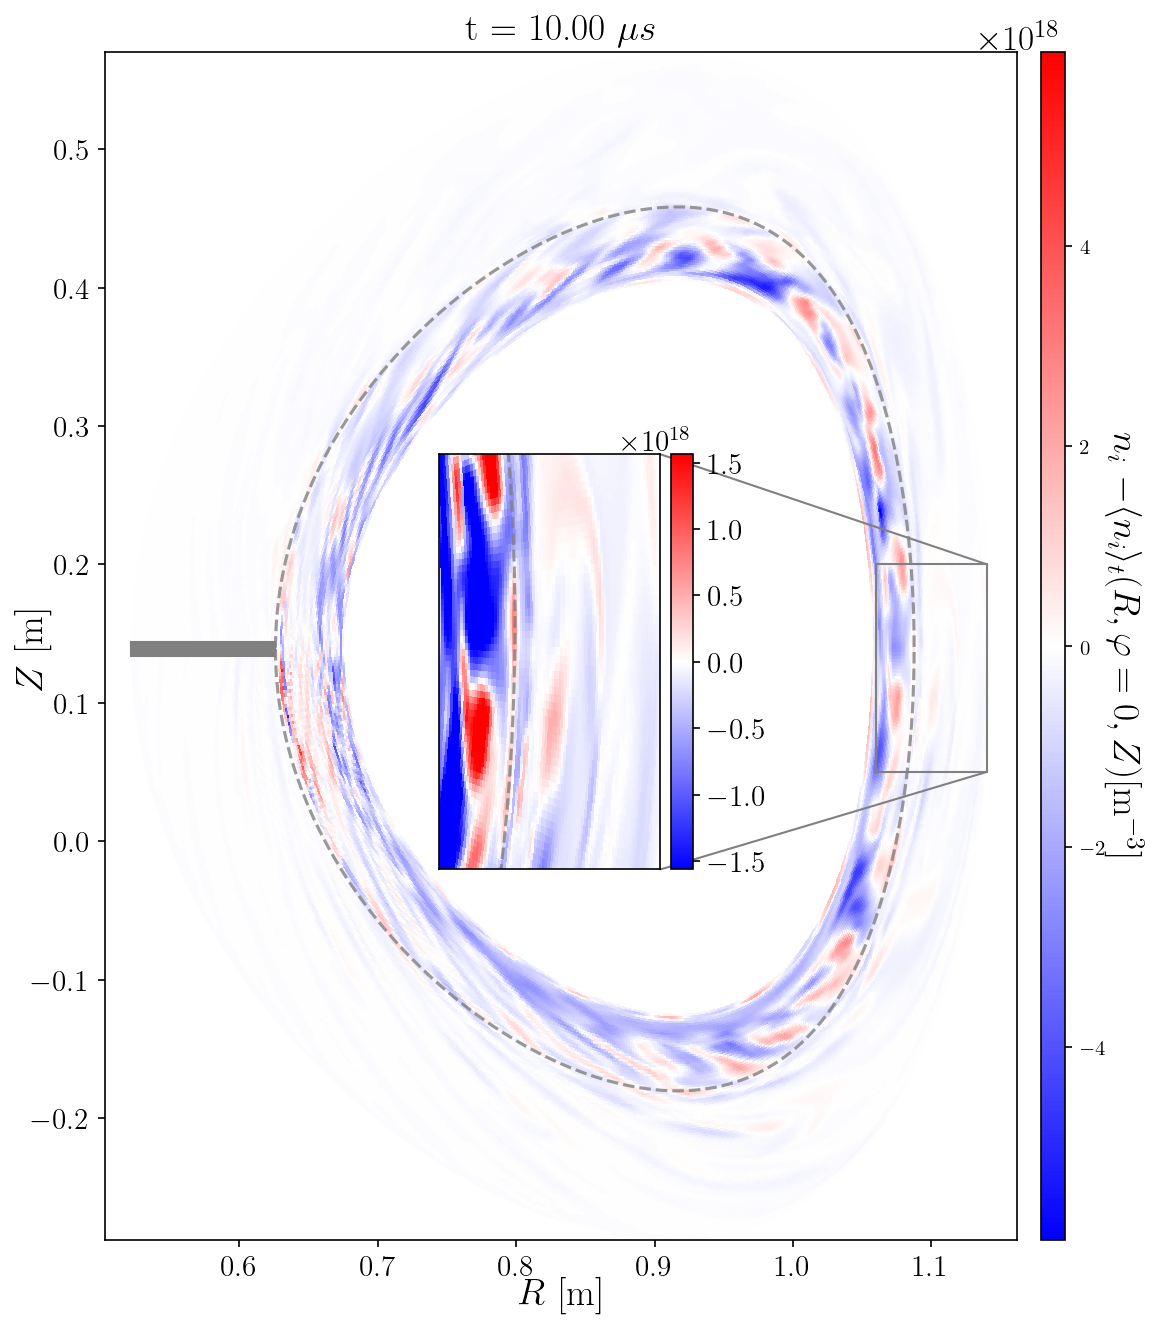

In [30]:
polproj.set_inset(index=0, lowerCornerRelPos=(0.35,0.3), xlim=[1.06,1.14], ylim=[0.05,0.2], zoom=2.0, markLoc=[1,4])
polproj.plot('ni',timeFrame=sim_frames[-10:],fluctuation='tavg')

or the relative fluctuations

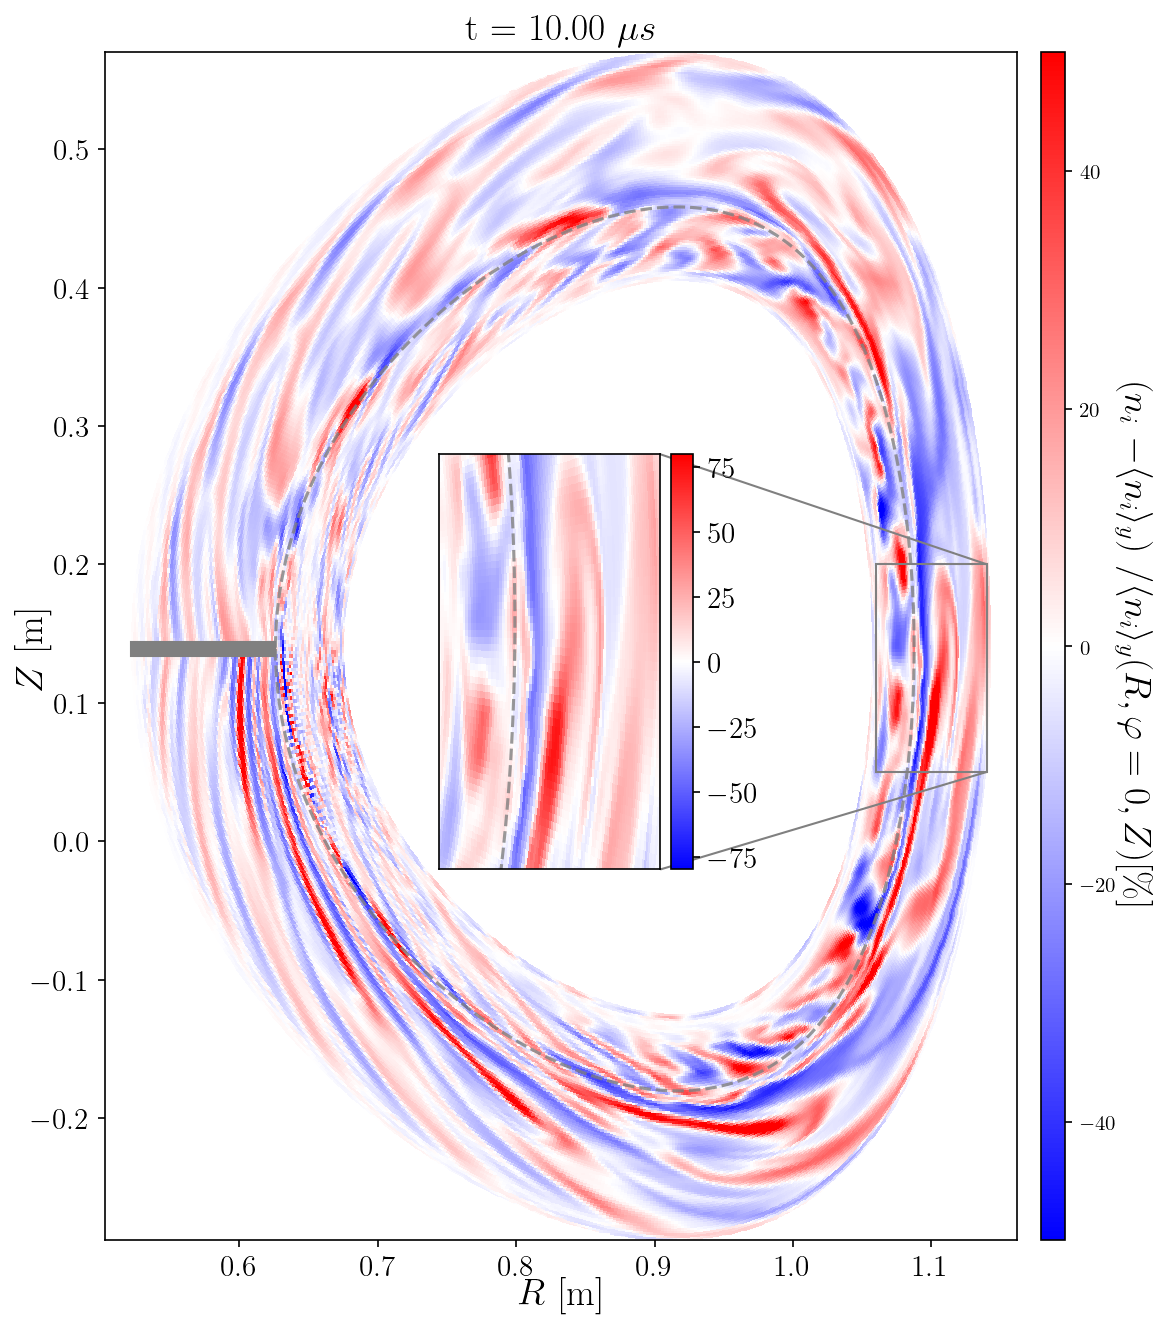

In [31]:
polproj.plot('ni',timeFrame=sim_frames[-1],fluctuation='relative_yavg',clim=[-50,50])

Or the radial component of the gradB drift
(here we also show how to customize the inset)

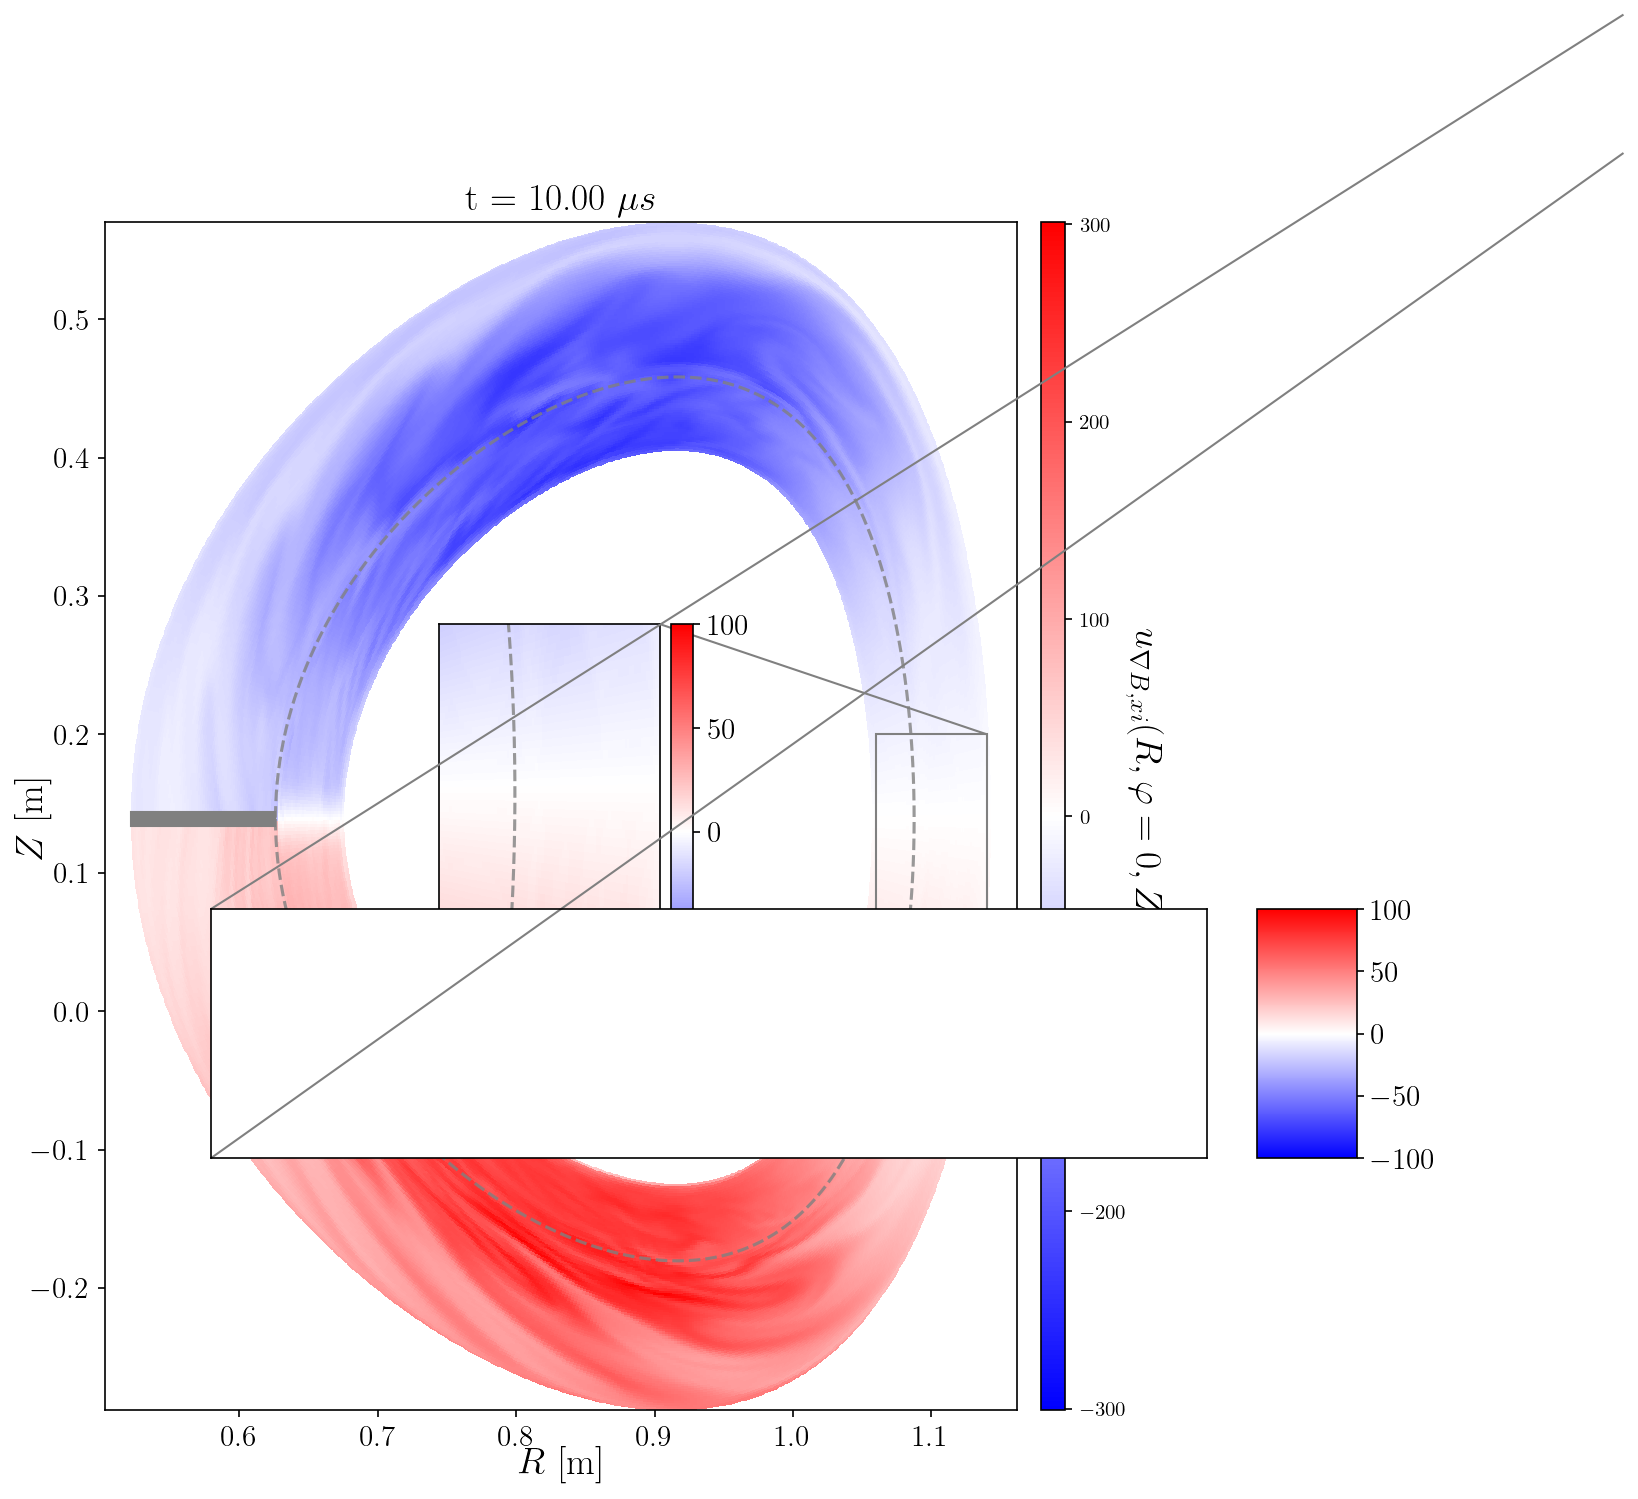

In [32]:
polproj.add_inset(zoom=1.8, xlim=[1.6,2.0], ylim=[0.62,0.72],
                 markLoc=[2,3], lowerCornerRelPos=(0.1,0.2))
climInset = [-100,100] # custom colorbar limits for the inset plot
polproj.plot('gradB_v_xi',timeFrame=sim_frames[-1],climInset=climInset)
polproj.reset_insets() # reset the inset to the default values

We can also display the y-average (t-average also available)

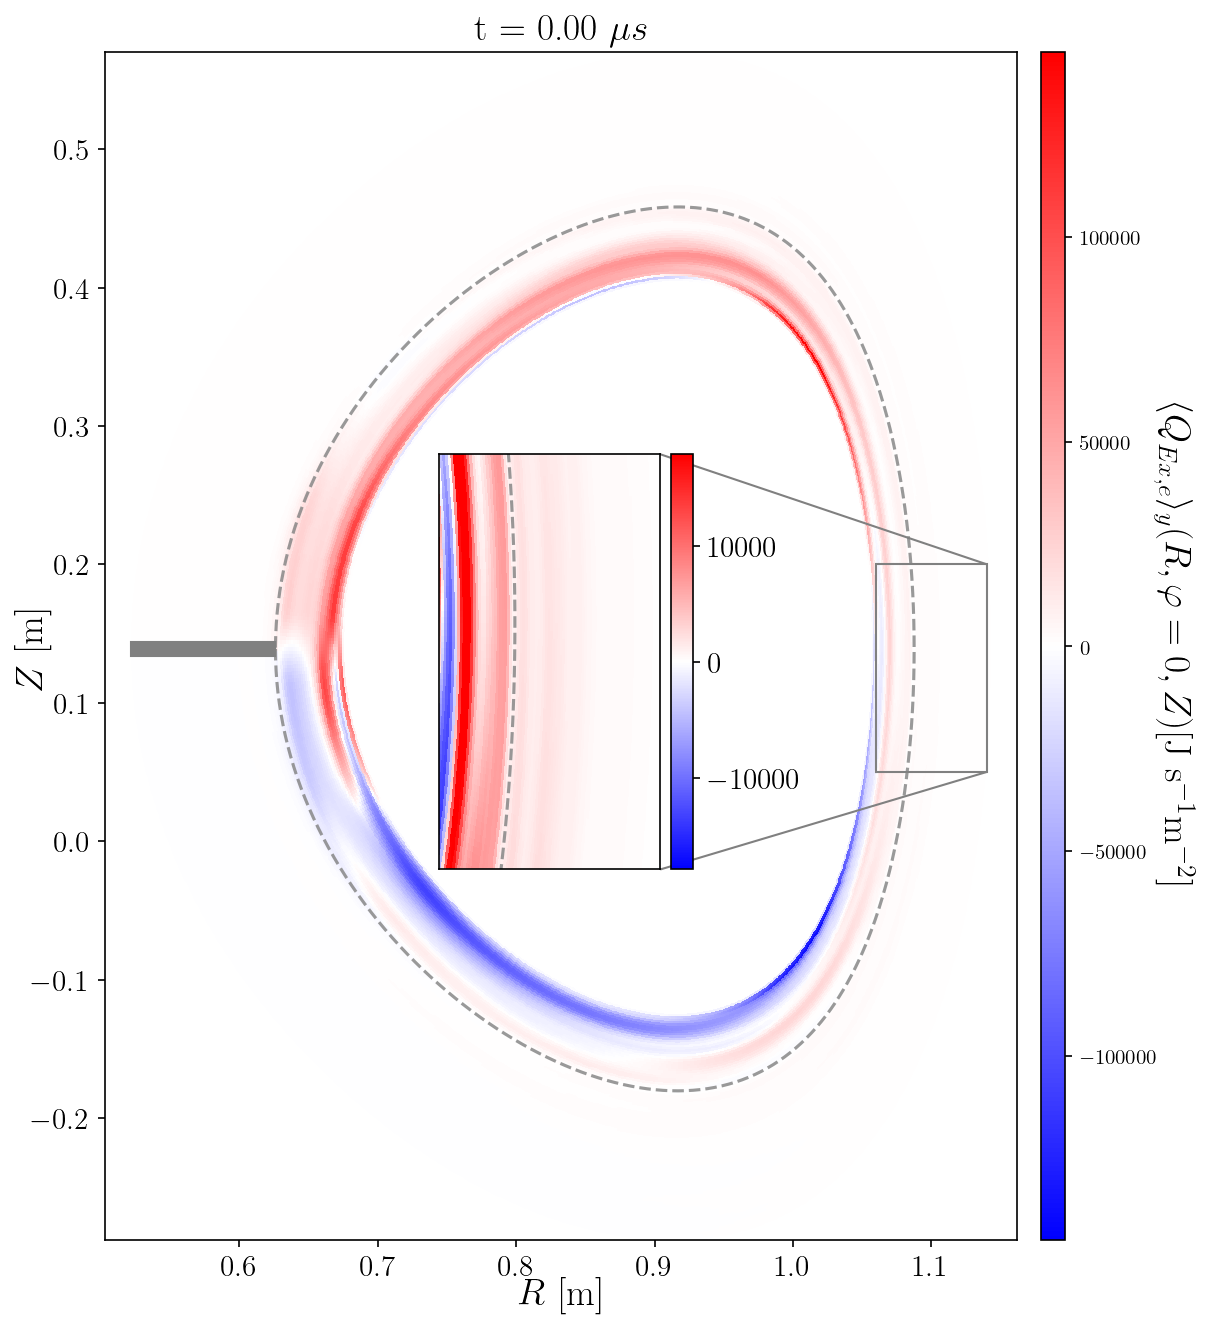

In [33]:
polproj.reset_insets() # reset the inset to the default values
polproj.plot('ExB_hflux_xe',timeFrame=sim_frames[0],average='yavg')

It is possible to plot the projection only in a provided radial interval.

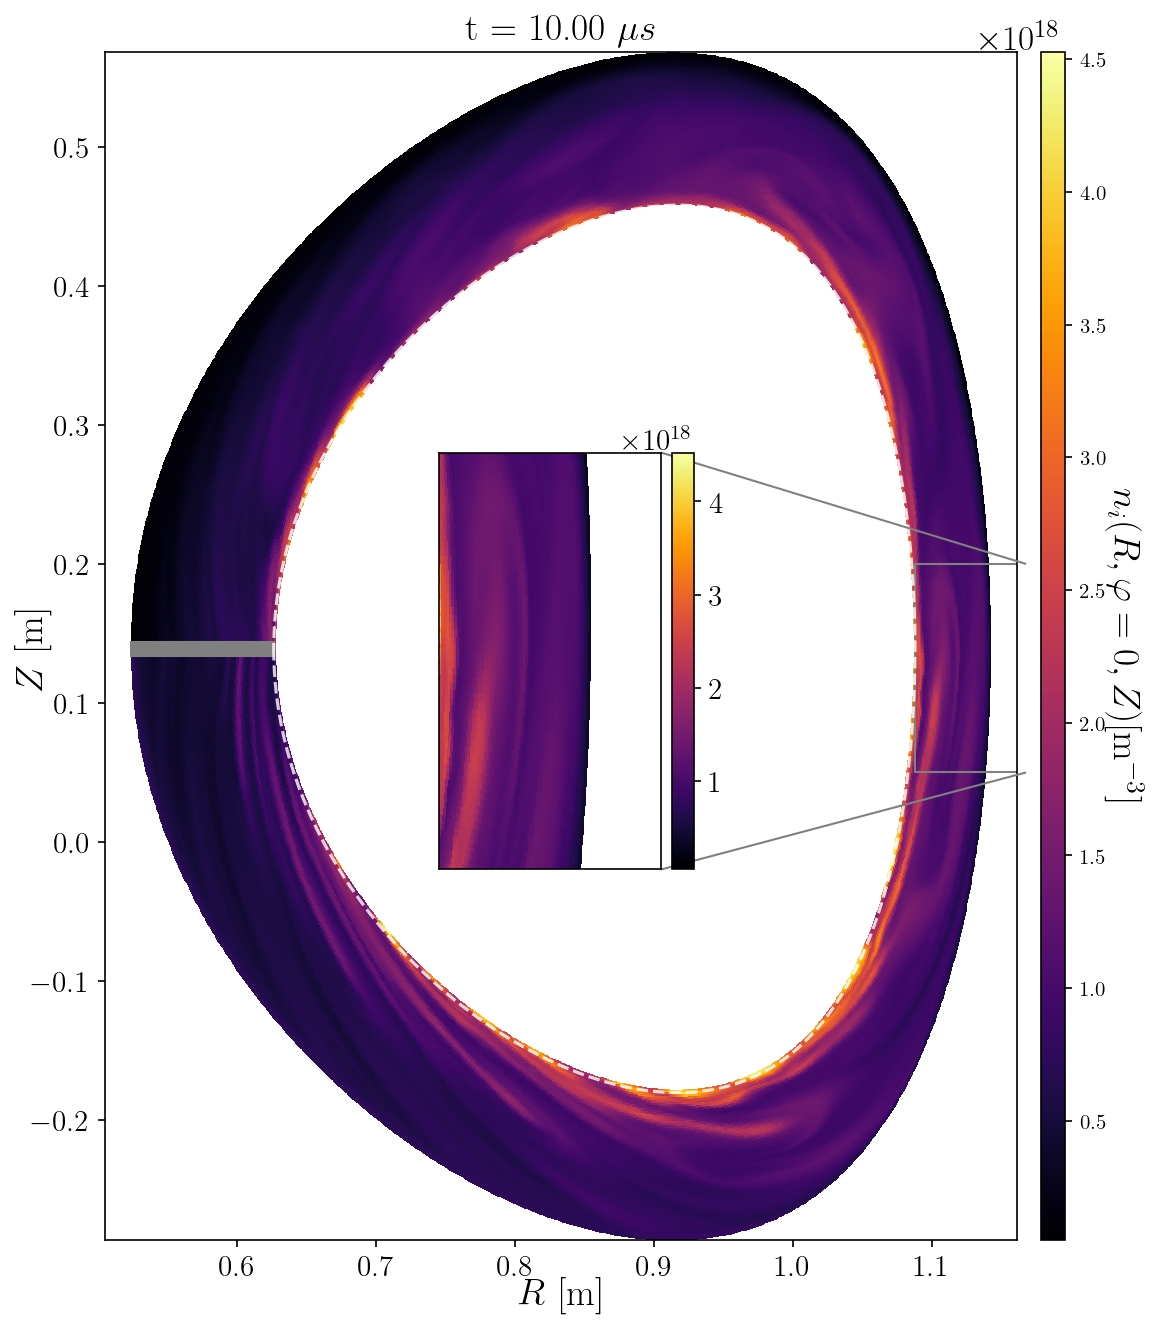

In [34]:
polproj_cut = pygkyl.PoloidalProjection()
 # Here we use rho=r/a but we can also use Rlim for specifying the major radius limits.
polproj_cut.setup(simulation,nzInterp=24,rholim=[1.0,1.5],timeFrame=sim_frames[0])
fieldname = 'ni'
timeFrame = sim_frames[-1]
polproj_cut.insets[0].xlim = [simulation.geom_param.R_LCFSmid, simulation.geom_param.Rmid_max]
polproj_cut.plot('ni',timeFrame=sim_frames[-1],colorScale='linear',clim=[],fluctuation='')

You can also create a movie of the poloidal projection

In [35]:
polproj.movie('ni',moviePrefix='gallery/mov_example_',timeFrames=sim_frames[-5:],colorScale='log')

Processing frames: 5/5... 
Creating movie gallery/mov_example_logni_RZ.gif...
movie gallery/mov_example_logni_RZ.gif created.


### 2.13 Flux surface projection plot <a id="fs_plot"></a>
Project the flux tube on a flux surface.

In [36]:
fsproj = pygkyl.FluxSurfProjection()

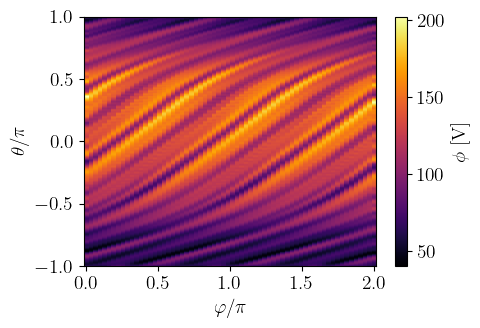

In [37]:
fsproj.setup(
    simulation, 
    Nint=64, # number of points in the toroidal direction
    rho=0.9, 
    smooth=True, 
    timeFrame=sim_frames[0] # time frame to load to get resolution info
    )

fsproj.plot(
    fieldName='phi', 
    timeFrame=sim_frames[-1], 
    fluctuation=''
    )

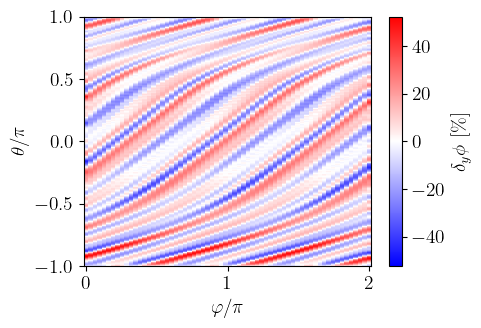

In [38]:
fsproj.plot(
    fieldName='phi', 
    timeFrame=sim_frames[-1], 
    fluctuation='yavg relative'
    )

### 2.14 Toroidal projection plot <a id="tor_plot"></a>
Project the flux tube on the tokamak geometry using `pyvista`.
Be sure to install the required modules:
```
# !{sys.executable} -m pip install pyvista trame trame-vtk trame-vuetify imageio ipywidgets
```
with `jupyter_backend`, we can have an interactive plot window if it is set to `'trame'` or `'html'`.

In [39]:
torproj = pygkyl.TorusProjection()
torproj.setup(simulation, 
              Nint_polproj=8, # number of interpolation points for the poloidal projection (24 is a good value)
              Nint_fsproj=8, # number of points along the toroidal direction (32 is a good value)
              phiLim = [0, 3*3.14/2], # toroidal angle limits in radians
              rhoLim = [1,-4], # radial limits, here in terms of indices
              timeFrame=sim_frames[0], # time frame to load to get resolution info
              )

In [40]:
# torproj.additional_text = {
#     'text': '5D simulation of DIII-D\nnegative triangularity edge plasma\n(PPPL & General Atomics)',
#     'position': 'lower_right',
#     'font_size': 12,
#     'name': 'title_text'
# }
torproj.logo_path = None # path to the logo image
torproj.show_colorbar = False
torproj.show_vessel = True
torproj.imgSize = (1440,960)
torproj.vessel_opacity_inner = 0.6
torproj.vessel_opacity = 0.6
torproj.vessel_metallic = 0.3
torproj.vessel_roughness = 1.0
torproj.vessel_rgb = (250,250,255)

In [41]:
fieldname = 'Ti'
fluctuation = 'yavg relative' # fluctuation field, if any (e.g., 'yavg')
timeFrame = sim_frames[-1]
logScale = False
clim = [-20,20]
filePrefix = ''
jupyter_backend='None' # set to 'trame' if you want to use the jupyter backend
cam1 = {
    'position':(2.3, 2.3, 0.75),
    'looking_at':(0, 0, 0),
        'zoom': 0.85
}
torproj.plot(fieldname, timeFrame, clim =clim, logScale = logScale, jupyter_backend=jupyter_backend, 
             filePrefix=filePrefix, cameraSettings=cam1,fluctuation=fluctuation)

Image saved as torproj_dTi.png


In [42]:
cam2 = {   
    'position':(0.83, 0.78, -0.1),
    'looking_at':(0., 0.74, -0.19),
    'zoom': 1.0
}
timeFrames = sim_frames[-3:]
torproj.movie(fieldName=fieldname, timeFrames=timeFrames, cameraPath=[cam1, cam2],
              fluctuation=fluctuation, clim=clim, logScale=logScale, filePrefix=filePrefix)

Processed frames: 3/3... 
Movie saved as torproj_movie_dTi.gif


## 3. Interfaces <a id="interfaces"></a>
Here we present a few examples of interfaces built in `pygkyl` to read other codes data.

### 3.1 Thungsten transport with Flan <a id="flan"></a>
After setting a path, one can use any of the above plotting routine to plot Thungsten fields obtained with Flan simulations (S. Zamperini).
The available Flan files are:
- 'flan_imp_density'
- 'flan_imp_counts'
- 'flan_imp_vX', 'flan_imp_vY', 'flan_imp_vZ'
It will use the metric and configuration of the Gkeyll simulation loaded previously.

In [43]:
if False: # set to True if you want to use the flan interface
    path = '/Users/ahoffman/personal_gkyl_scripts/sim_data_dir_example/flan_data/iwl_test.nc'
    simulation.set_flandata(path)

In [44]:
if False: # set to True if you want to use the flan interface
    cut_dir = 'x'
    cut_coord = ['avg','avg']
    fieldnames = ['flan_imp_density']
    frames = simulation.flanframes[:]
    figout = []
    clim = [0,1e-6]
    pygkyl.plot_utils.plot_1D_time_evolution(simulation, cut_dir, cut_coord, fieldnames, twindow=frames,
                                            space_time=True, plot_type='imshow', figout=figout, clim=clim)

### 3.2 Local GK flux tube simulations with GYACOMO <a id="gyacomo"></a>
We can also read simulations from GYACOMO (Hoffmann et al. 2023) and use all the routines developped above. 
One has to decide on the region of study as GYACOMO is a local code.

In [45]:
if False: # set to True if you want to use the GYACOMO interface
    path = '/Users/ahoffman/gyacomo/simulations/cyclone/outputs_00.h5'
    simulation = pygkyl.simulation_configs.import_config('gyacomo', path)

    sim_frames = simulation.available_frames['field']
    cut_dir = 'xy'
    cut_coord = 0.0 
    time_frame = sim_frames[-1] 
    fieldnames = ['phi']
    pygkyl.plot_utils.plot_2D_cut(simulation, cut_dir, cut_coord, time_frame,fieldnames,plot_type='imshow')